In [32]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt

In [15]:
dataset = load_breast_cancer()

In [16]:
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.Series(dataset.target, name="target")
X, y = shuffle(X, y, random_state=42)

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


In [17]:
features = X.columns.tolist()
print(features)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [18]:
from sklearn.model_selection import ShuffleSplit


In [19]:
shuffle_split_cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [20]:
# Manual One-Hot Encoding for target
y_df = y.to_frame(name='target')
y_df['target_0'] = (y_df['target'] == 0).astype(int)
y_df['target_1'] = (y_df['target'] == 1).astype(int)

print(y_df[['target', 'target_0', 'target_1']].head())

     target  target_0  target_1
204       1         0         1
70        0         1         0
131       0         1         0
431       1         0         1
540       1         0         1


In [21]:
d_df=y_df[['target_0', 'target_1']]

In [22]:
print(d_df)

     target_0  target_1
204         0         1
70          1         0
131         1         0
431         0         1
540         0         1
..        ...       ...
71          0         1
106         0         1
270         0         1
435         1         0
102         0         1

[569 rows x 2 columns]


In [23]:
#let's load the data and split into training and test
features, labels=load_breast_cancer(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [24]:
from sklearn.model_selection import cross_validate

lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()), ("linear_regression", LogisticRegression())])
lin_reg_cv_results = cross_validate(lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv, scoring="neg_mean_absolute_error")
lin_reg_errors= pd.Series(-lin_reg_cv_results['test_score'], name="lin_reg_errors")

In [25]:
print(lin_reg_cv_results)

{'fit_time': array([0.02634263, 0.01243234, 0.01175404, 0.01033163, 0.01027536,
       0.01087022, 0.01052117, 0.00976515, 0.01047897, 0.02232385]), 'score_time': array([0.00457454, 0.00414753, 0.00403404, 0.00406766, 0.00426483,
       0.00393128, 0.00414348, 0.00379992, 0.00936985, 0.00901866]), 'test_score': array([-0.03296703, -0.01098901, -0.05494505, -0.03296703, -0.03296703,
       -0.04395604, -0.01098901, -0.04395604, -0.02197802, -0.02197802])}


In [26]:
print(lin_reg_errors)

0    0.032967
1    0.010989
2    0.054945
3    0.032967
4    0.032967
5    0.043956
6    0.010989
7    0.043956
8    0.021978
9    0.021978
Name: lin_reg_errors, dtype: float64


In [12]:
def Dummy_regressor_baseline(strategy,  constant_val=None ,quantile_val=None):
  baseline_model_median = DummyRegressor(strategy=strategy, constant=constant_val, quantile=quantile_val)
  baselline_median_cv_results = cross_validate(baseline_model_median, train_features, train_labels, cv=shuffle_split_cv, scoring="neg_mean_absolute_error",n_jobs=2)
  return pd.Series(-baselline_median_cv_results['test_score'], name=f"{strategy}_errors")


In [27]:
baseline_median_cv_results_errors=Dummy_regressor_baseline(strategy="median")
baseline_mean_cv_results_errors=Dummy_regressor_baseline(strategy="mean")
baseline_constant_cv_results_errors=Dummy_regressor_baseline(strategy="constant", constant_val=2)
baseline_quantile_cv_results_errors=Dummy_regressor_baseline(strategy="quantile", quantile_val=0.55)

In [29]:
dummy_error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_errors, baseline_mean_cv_results_errors, baseline_constant_cv_results_errors, baseline_quantile_cv_results_errors], axis=1)
dummy_error_df.columns = ["lin_reg_errors", "baseline_median_errors", "baseline_mean_errors", "baseline_constant_errors", "baseline_quantile_errors"]

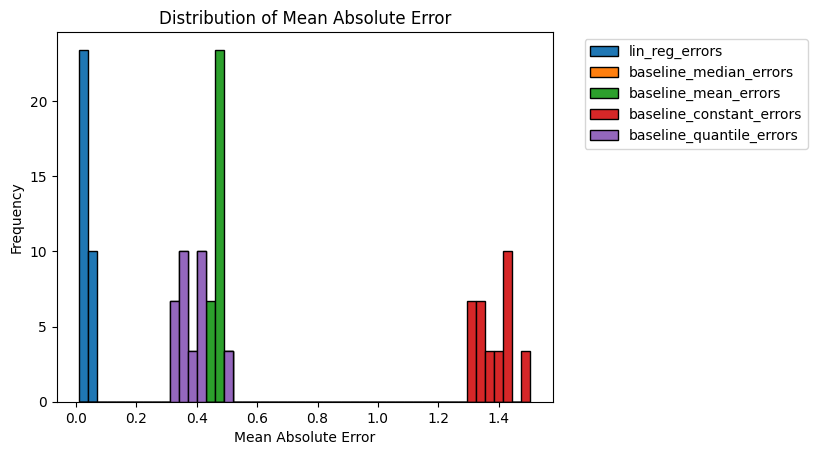

In [33]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Frequency")
_=plt.title("Distribution of Mean Absolute Error")

In [46]:

rng = np.random.default_rng(0)
X_miss = X.copy()
col = "mean radius"
n = len(X_miss)
idx = rng.choice(n, size=int(0.05*n), replace=False)
X_miss.loc[X_miss.index[idx], col] = np.nan

pipe_mean = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("clf", LogisticRegression(max_iter=1000))
])
Xtr, Xte, ytr, yte = train_test_split(X_miss, y, test_size=0.2, random_state=42, stratify=y)
pipe_mean.fit(Xtr, ytr)
print("Mean imputation acc:", accuracy_score(yte, pipe_mean.predict(Xte)))

Mean imputation acc: 0.9385964912280702


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
X_enc = X.copy()
X_enc['radius_cat'] = pd.qcut(X_enc['mean radius'], q=3, labels=['small','medium','large'])
cat_cols = ['radius_cat']
num_cols = [c for c in X_enc.columns if c not in cat_cols]

pre_no_scale = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", SimpleImputer(strategy="mean"), num_cols)
])
pipe = Pipeline([("pre", pre_no_scale), ("clf", LogisticRegression(max_iter=2000))])
Xtr, Xte, ytr, yte = train_test_split(X_enc, y, test_size=0.2, random_state=42, stratify=y)
pipe.fit(Xtr, ytr)
print("OHE no scaling acc:", accuracy_score(yte, pipe.predict(Xte)))


OHE no scaling acc: 0.9473684210526315


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer()), ("mms", MinMaxScaler())]), X.columns)
])
pipe = Pipeline([("pre", pre),
                 ("sel", SelectKBest(score_func=chi2, k=20)),
                 ("clf", LogisticRegression(max_iter=2000))])
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipe.fit(Xtr, ytr)
print("Acc with k=20:", accuracy_score(yte, pipe.predict(Xte)))

Acc with k=20: 0.9122807017543859


In [49]:
X_log = X.copy()
X_log['mean area'] = np.log1p(X_log['mean area'])
Xtr, Xte, ytr, yte = train_test_split(X_log, y, test_size=0.2, random_state=42, stratify=y)
pipe = Pipeline([("imp", SimpleImputer()), ("clf", LogisticRegression(max_iter=2000))])
pipe.fit(Xtr, ytr)
print("Acc with log(mean area):", accuracy_score(yte, pipe.predict(Xte)))

Acc with log(mean area): 0.9385964912280702
